# K - Nearest Neighbors

In [ ]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

sys.path.append('../src') # permite importar modulos locales
pd.options.display.max_columns = None # permite mostrar todas las columnas de los DataFrames

In [ ]:
from ds_preprocessing import DataSetPreprocessor
from arff_helper import DataSet
from metrics import accuracy_score
from kfold import KFold
from classifier import KNNClassifier

## Preprocesamiento del dataset de entrenamiento

Se preprocesa el dataset de entrenamiento para transformarlo en otro que permita calcular distancias euclidianas entre las instancias

In [ ]:
training_ds = DataSet()
training_ds.load_from_arff('../datasets/Autism-Adult-Training-Subset.arff')
preprocessor = DataSetPreprocessor(training_ds, 'Class/ASD')
preprocessed_training_df = preprocessor.transform_to_rn()

## Testeo general

### Resultados de predicciones 

El objetivo aquí es observar los valores devueltos para el atributo objetivo (```YES``` o ```NO```). Se toman N instancias al azar del conjunto de entrenamiento y se imprimen los valores. 

In [ ]:
N = 5
test_df = preprocessed_training_df.sample(N)
training_df = preprocessed_training_df.loc[~preprocessed_training_df.index.isin(test_df.index), :]\
    .reset_index()\
    .drop(columns=['index'], axis=1)
test_df = test_df\
    .reset_index()\
    .drop(columns=['index'], axis=1)

classifier = KNNClassifier(1, target_attribute='Class/ASD')
classifier.fit(training_df)

print()
for i in range(N):
    predicted_value = classifier.predict(test_df.loc[i])
    real_value = test_df.loc[i]['Class/ASD']
    print('Real value : {}, Predicted: {}'.format(real_value, predicted_value))
print()

### Instancias vecinas

El objetivo aquí es observar las instancias vecinas (determinadas por K) de las instancias que se quieren predecir para ver las similitudes y/o diferencias. La primer instancia en la tabla corresponde a la que se quiere predecir y las siguientes son sus vecinas. Se reordenan las columnas de dicha tabla de forma que las dos últimas columnas sean: 

- ```Class/ASD``` : atributo objetivo 
- ```distance``` : distancia entre la instancia correspondiente a la fila y la instancia que se quiere predecir (primer fila)

In [ ]:
instance_index = 536 # indice en el DataFrame original
instance = preprocessed_training_df.iloc[[instance_index]]
training_df = preprocessed_training_df.loc[~preprocessed_training_df.index.isin([instance_index]), :]\
    .reset_index()\
    .drop(columns=['index'], axis=1)
instance = instance.reset_index()\
    .drop(columns=['index'], axis=1)

classifier = KNNClassifier(3, target_attribute='Class/ASD')
classifier.fit(training_df)
(predicted_value, neighbours) = classifier.predict(instance.loc[0], return_neighbours=True)
print('\nPredicted value = {}'.format(predicted_value))
df = pd.concat([instance, neighbours])
cols = list(df.columns.values)
cols.pop(cols.index('Class/ASD'))
cols.pop(cols.index('distance')) 
df[cols+['Class/ASD','distance']]

## Evaluación del algoritmo

<br/>

Utilizando K-Fold y una métrica de evaluación (ej.: accuracy, precision, etc.), el objetivo es obtener mas resultados que solamente los K que se obtendrían con la estrategia de evaluación clásica variando K veces el conjunto de entrenamiento. 

A continuación se resumen los pasos :

<br/>

1. Sea $R$ una lista vacía, repetir ```n``` veces :

    1. Instanciar ```KFold``` para particionar el conjunto de entrenamiento ```t``` en ```k_for_k_fold``` partes:<br/><br/><br/>&nbsp;&nbsp;&nbsp;&nbsp;```kf = KFold(n_splits=k_for_k_fold, do_shuffle=True)```<br/><br/>            
    2. Obtener los índices de las particiones de ```t``` :<br/><br/>&nbsp;&nbsp;&nbsp;&nbsp;```L = kf.split(t)```<br/><br/>
    3. Sea $L = [(T_{1}, E_{1}), ... , (T_{k\_for\_k\_fold}, E_{k\_for\_k\_fold})]$ el particionamiento con ```KFold```, para cada tupla $(T_{i}, E_{i})$ con los conjuntos de entrenamiento y evaluación respectivamente :
    
        1. Entrenar el algoritmo con el conjunto $T_{i}$
        2. Predecir los valores del atributo objetivo para todas las instancias en $E_{i}$
        3. Comparar los valores predecidos con los valores ya marcados en $E_{i}$ utilizando alguna métrica (ej.: accuracy).
        4. Agregar el resultado de la métrica a $R$.

<br/>

Aclaraciones: 
   - En cada tupla $(T_{i}, E_{i})$, $T_{i}$ y $E_{i}$ no son las instancias de ```e```, sino las listas de índices para obtener las instancias de ```t``` para entrenamiento y evaluación respectivamente. 
   - Al final $R$ tendrá ```n*k_for_k_fold``` resultados de evaluar con la métrica elegida.
   - A pesar de que se repiten ```n``` veces las ```k_for_k_fold``` pasadas de K-Fold, al utilizar el parámetro ```do_shuffle```, todo el dataset ```t``` será mezclado antes de realizar el particionamiento. Sin esto, las ```n``` pasadas de ```K-Fold``` darían exactamente los mismos resultados.
        


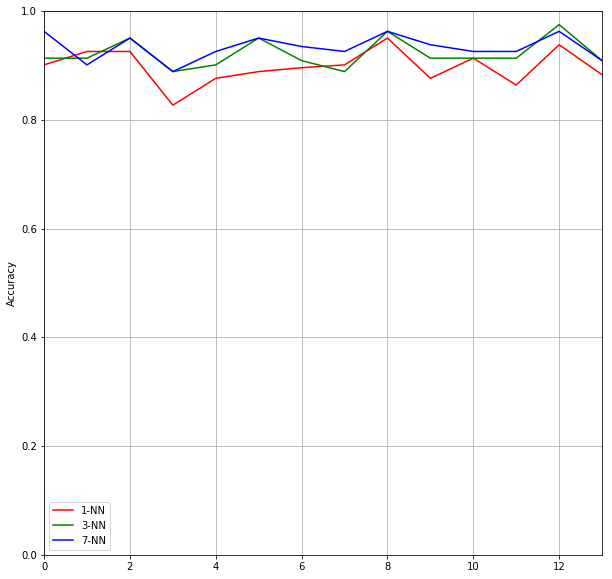

In [29]:
n = 2
k_for_k_fold = 7
target_attribute='Class/ASD'
accuracies_1_nn = []
accuracies_3_nn = []
accuracies_7_nn = []
classifier_1_nn = KNNClassifier(1, target_attribute)
classifier_3_nn = KNNClassifier(3, target_attribute)
classifier_7_nn = KNNClassifier(7, target_attribute)

for i in range(n):
    
    kf = KFold(n_splits=k_for_k_fold, do_shuffle=True)
    indexes = kf.split(preprocessed_training_df)
    
    for test_indexes, training_indexes in indexes:
        
        df_test = preprocessed_training_df.iloc[test_indexes]
        df_train = preprocessed_training_df.iloc[training_indexes] \
            .reset_index()\
            .drop(columns=['index'], axis=1) # prevent warning ../src/k_nearest_neighbor.py:31: SettingWithCopyWarning
        
        classifier_1_nn.fit(df_train)
        classifier_3_nn.fit(df_train)
        classifier_7_nn.fit(df_train)
        
        y_predicted_1_nn = df_test.apply(lambda row: classifier_1_nn.predict(row), axis=1)
        y_predicted_3_nn = df_test.apply(lambda row: classifier_3_nn.predict(row), axis=1)
        y_predicted_7_nn = df_test.apply(lambda row: classifier_7_nn.predict(row), axis=1)
        
        y_true = df_test[target_attribute]
        
        accuracies_1_nn.append(accuracy_score(y_predicted_1_nn, y_true))
        accuracies_3_nn.append(accuracy_score(y_predicted_3_nn, y_true))
        accuracies_7_nn.append(accuracy_score(y_predicted_7_nn, y_true))
        
        print('[' + '>'*len(accuracies_1_nn) + ' '*((n*k_for_k_fold)-len(accuracies_1_nn)) + ']', end='\r')
        
plt.figure(figsize=(10,10))
plt.ylabel('Accuracy')
plt.axis([0, (n*k_for_k_fold)-1, 0, 1])
plt.grid(True)

plt.plot(accuracies_1_nn, color='r', label='1-NN')
plt.plot(accuracies_3_nn, color='g', label='3-NN')
plt.plot(accuracies_7_nn, color='b', label='7-NN')

plt.legend(loc=0)
plt.show()